# Portfolio Management
- In this section we will use the strategy we created to manage a portfolio of stocks. We will first build a trading model that include constraints such as maximum number of stocks, short-selling constraints, and transaaction costs.
- We will regress our strategies against each other to find the best combination. 
- We will get weights from the returns predictions and run our final model. 
- We will compare our results against two benchmarks: the market and a markowitz portfolio. 
- We will discuss in the appendix possible improvements. 

In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import random 
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import cvxpy as cp
def first_weights_given_returns(
    returns: np.ndarray,
    prev_weights: np.ndarray,
    tc: float = 0.001
) -> tuple[np.ndarray, float]:
    """
    Compute the weight vector w that maximizes:
        returns^T w  -  tc * ||w - prev_weights||_1
    subject to sum(w) == 1 and w >= 0.

    Parameters
    ----------
    returns : np.ndarray, shape (n,)
        Forecasted returns for each asset.
    prev_weights : np.ndarray, shape (n,)
        Previous weight allocation (must sum to 1, nonnegative).
    tc : float, default=0.001
        Transaction‐cost coefficient (multiplies the L1 distance).

    Returns
    -------
    new_weights : np.ndarray, shape (n,)
        The optimized weights (sum to 1, all ≥ 0).
    total_cost : float
        The realized transaction cost: tc * ||new_weights - prev_weights||_1
    """
    # Ensure inputs are 1-D arrays of equal length
    if returns.ndim != 1 or prev_weights.ndim != 1:
        raise ValueError("`returns` and `prev_weights` must be one‐dimensional arrays.")
    if returns.shape[0] != prev_weights.shape[0]:
        raise ValueError("`returns` and `prev_weights` must have the same length.")
    
    n = returns.shape[0]
    
    # CVXPY variable for new weights
    weights = cp.Variable(n)
    
    # L1 transaction‐cost term: ||weights - prev_weights||_1
    l1_diff = cp.norm1(weights - prev_weights)
    total_cost_expr = tc * l1_diff
    
    # Objective: maximize returns^T * weights - total_cost_expr
    objective = cp.Maximize(returns @ weights - total_cost_expr)
    
    # Constraints: sum(weights) == 1, weights >= 0
    constraints = [
        cp.sum(weights) == 1,
        weights >= -0.5
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    
    # Extract the numeric solution
    w_opt = weights.value.flatten()
    # Clip any tiny negatives, then re‐normalize to ensure sum-to-1 exactly
    w_opt = np.maximum(w_opt, 0.0)
    w_opt /= w_opt.sum()
    
    # Compute the actual transaction cost as a float
    total_cost = tc * np.linalg.norm(w_opt - prev_weights, ord=1)
    
    return w_opt, total_cost


In [4]:
def model_evaluation(weights:np.ndarray, real_returns:np.ndarray, total_cost:float):
    return sum(weights*real_returns) - total_cost

In [5]:
def strategy(
    returns: pd.DataFrame,
    prev_weights: np.ndarray = None,
    tc: float = 0.001
) -> tuple[np.ndarray, float]:
    """
    Execute the trading strategy based on forecasted returns and previous weights.

    Parameters
    ----------
    returns : pd.DataFrame
        DataFrame with forecasted returns for each asset (rows = time, cols = assets).
    prev_weights : np.ndarray
        Previous weight allocation (must sum to 1, nonnegative). If None, starts as zeros.
    tc : float, default=0.001
        Transaction‐cost coefficient.

    Returns
    -------
    new_weights : np.ndarray
        A (T × N) array of optimized weights for each time t (each row sums to 1, all ≥ 0).
    total_cost : float
        The sum of transaction costs incurred over all T periods.
    """
    # Number of periods (T) and number of assets (N)
    T, N = returns.shape

    # If no prev_weights provided, start with a zero vector of size N
    if prev_weights is None or len(prev_weights) == 0:
        w_prev = np.zeros(N)
    else:
        w_prev = prev_weights.copy()

    # Prepare an array to hold weights at each time t, and accumulate costs
    weights_history = np.zeros((T, N))
    total_cost = 0.0

    # Loop over each time index t
    for t in range(T):
        # Extract the t-th row of returns as a 1D array of length N
        returns_array = returns.iloc[t].to_numpy()
        
        # Compute new weights and transaction cost at time t
        w_new, cost_t = first_weights_given_returns(returns_array, w_prev, tc)
        
        # Store results
        weights_history[t, :] = w_new
        total_cost += cost_t
        
        # Update w_prev for the next iteration
        w_prev = w_new

    return weights_history, total_cost


### We run some simulations 

In [6]:
def simulation(iterations: int = 10):
    """
    Run the simulation for a specified number of iterations.
    
    Parameters
    ----------
    iterations : int, default=10
        Number of iterations to run the simulation.
    """
    total_returns=0
    returns_time_zero = np.random.normal(0.001, 0.01, size=3852)
    previous_weights = returns_time_zero / returns_time_zero.sum()
    total_returns_vector= []
    real_returns_vector= []
    for i in range(iterations):
        returns_time_1 = np.random.normal(0.001, 0.01, size=3852)
        flag = np.random.binomial(n=1, p=0.55)
        if flag==1:
            noise = np.random.normal(0.00, 0.01, size=3852)
        else:
            noise = np.random.normal(-0.002, 0.01, size=3852) 
        real_returns = returns_time_1 + noise
        weights, total_cost = first_weights_given_returns(returns_time_1, prev_weights=previous_weights, tc=0.001)
        previous_weights = weights
        profit=model_evaluation(weights, real_returns, total_cost)
        total_returns += profit
        total_returns_vector.append(profit)
        real_returns_vector.append(real_returns.mean())
    print(f"Total returns over {iterations} iterations: {total_returns:.4f}")
    return total_returns,total_returns_vector, real_returns_vector


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Total returns over 15 iterations: 0.4424


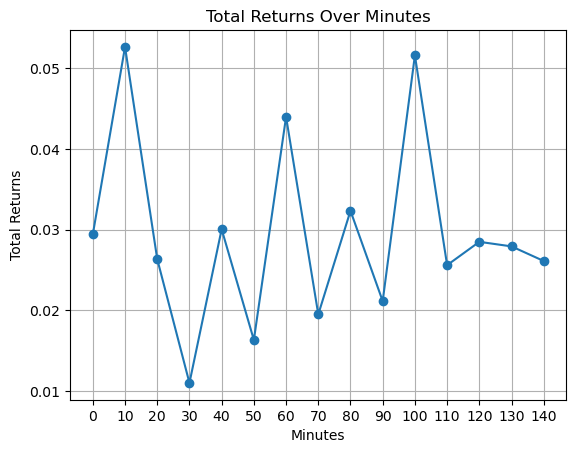

In [7]:
_,total_returns_vector,real_returns_vector=simulation(15)
plt.plot(total_returns_vector, marker='o')
#I need for the x-axis to be minutes, every iteration is 10 minutes
plt.xticks(ticks=range(len(total_returns_vector)), labels=[f"{i*10}" for i in range(len(total_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

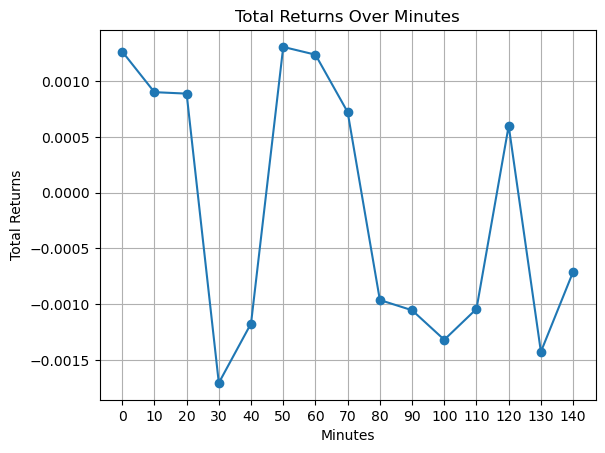

In [8]:
plt.plot(real_returns_vector, marker='o')
plt.xticks(ticks=range(len(real_returns_vector)), labels=[f"{i*10}" for i in range(len(real_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

### Let's now build a second strategy based on our predictions.


In [ ]:
df=pd.read_parquet('/data/high_10m.parquet')
df.fillna(0, inplace=True)
df['DATE']= pd.to_datetime(df['DATE'])
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/emanueledurante/data/high_10m.parquet'

In [ ]:
def markowitz_weights_given_returns(
    returns: np.ndarray,
    prev_weights: np.ndarray,
    date: str,
    tc: float = 0.001,
    df: pd.DataFrame = None
    )-> tuple[np.ndarray, float]:
    """
    Compute the weight vector w that maximizes:
        returns^Tw-tc * ||w - prev_weights||_1-1/2 * w^T Sigma w
    subject to sum(w) == 1 and w >= -0.5
    Parameters
    ----------
    returns : np.ndarray, shape (n,)
        Forecasted returns for each asset.
    prev_weights : np.ndarray, shape (n,)
        Previous weight allocation (must sum to 1, nonnegative).
    tc : float, default=0.001
        Transaction‐cost coefficient (multiplies the L1 distance).
    df : pd.DataFrame, to calculate the covariance matrix Sigma
    date : str, the date for which we want to calculate the covariance matrix
    Returns
    -------
    new_weights : np.ndarray, shape (n,)
        The optimized weights (sum to 1, all ≥ -0.5).
    total_cost : float
        The realized transaction cost: tc * ||new_weights - prev_weights||_1
    """
    # Ensure inputs are 1-D arrays of equal length
    if returns.ndim != 1 or prev_weights.ndim != 1:
        raise ValueError("`returns` and `prev_weights` must be one‐dimensional arrays.")
    if returns.shape[0] != prev_weights.shape[0]:
        raise ValueError("`returns` and `prev_weights` must have the same length.")
    
    n = returns.shape[0]
    df_before = df.loc[df['DATE'] < date]

    # Pivot so that each SYMBOL becomes its own column
    #    and each row is a (DATE, TIME) pair:
    df_wide = df_before.pivot(
            index=["DATE", "TIME"],
            columns="SYMBOL",
            values="RETURN"
    )
    df_wide = df_wide.fillna(0.0)
    sigma_df = df_wide.cov()
    # CVXPY variable for new weights
    weights = cp.Variable(n)

    sigma_hat = sigma_df.values
    sigma_hat = 0.5 * (sigma_hat + sigma_hat.T) #PORCODIO CVXPY STAI ZITTO DIOCANE SE NON E' SIMMETRICA ALLA DIOCANE DI QUINTA CIFRA DECIMALE
    variance_term = cp.quad_form(weights, sigma_hat)
    # L1 transaction‐cost term: ||weights - prev_weights||_1
    l1_diff = cp.norm1(weights - prev_weights)
    # Total cost expression
    total_cost_expr = tc * l1_diff
    
    # Objective: maximize returns^T * weights - total_cost_expr
    objective = cp.Maximize(returns @ weights - total_cost_expr- 0.5 * variance_term)
    
    # Constraints: sum(weights) == 1, weights >= 0
    constraints = [
        cp.sum(weights) == 1,
        weights >= -0.5
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    
    # Extract the numeric solution
    w_opt = weights.value.flatten()
    # Clip any tiny negatives, then re‐normalize to ensure sum-to-1 exactly
    w_opt = np.maximum(w_opt, 0.0)
    w_opt /= w_opt.sum()
    
    # Compute the actual transaction cost as a float
    total_cost = tc * np.linalg.norm(w_opt - prev_weights, ord=1)
    
    return w_opt, total_cost


### Simulations: if you are not John Von Neumann, you will not be able to run this code in a reasonable time.

In [ ]:
num_symbols = df["SYMBOL"].nunique()
print(f"Number of unique symbols: {num_symbols}")

Number of unique symbols: 9509


In [219]:
def simulation_markowitz(iterations: int = 10):
    """
    Run the simulation for a specified number of iterations.
    
    Parameters
    ----------
    iterations : int, default=10
        Number of iterations to run the simulation.
    """
    total_returns=0
    returns_time_zero = np.random.normal(0.001, 0.01, size=9372)
    previous_weights = returns_time_zero / returns_time_zero.sum()
    total_returns_vector= []
    real_returns_vector= []
    for i in range(iterations):
        returns_time_1 = np.random.normal(0.001, 0.01, size=9372)
        flag = np.random.binomial(n=1, p=0.55)
        if flag==1:
            noise = np.random.normal(0.00, 0.01, size=9372)
        else:
            noise = np.random.normal(-0.002, 0.01, size=9372) 
        real_returns = returns_time_1 + noise
        weights, total_cost = markowitz_weights_given_returns(returns_time_1, prev_weights=previous_weights, tc=0.001, date='2021-12-10', df=df)
        previous_weights = weights
        profit=model_evaluation(weights, real_returns, total_cost)
        total_returns += profit
        total_returns_vector.append(profit)
        real_returns_vector.append(real_returns.mean())
    print(f"Total returns over {iterations} iterations: {total_returns:.4f}")
    return total_returns,total_returns_vector, real_returns_vector


(9372, 9372)
Total returns over 1 iterations: 0.0314


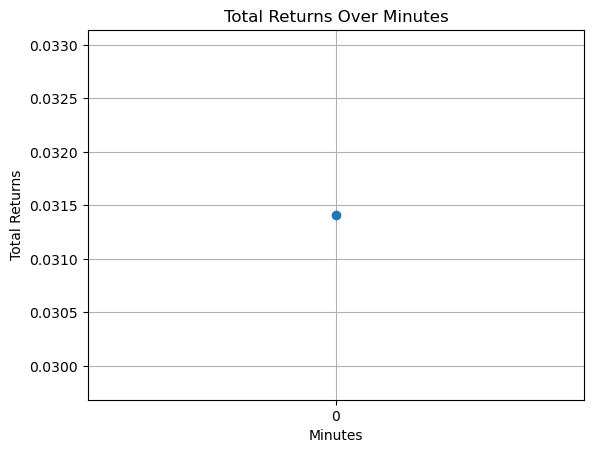

In [ ]:
_,total_returns_vector,real_returns_vector=simulation_markowitz(5)
plt.plot(total_returns_vector, marker='o')
#I need for the x-axis to be minutes, every iteration is 10 minutes
plt.xticks(ticks=range(len(total_returns_vector)), labels=[f"{i*10}" for i in range(len(total_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

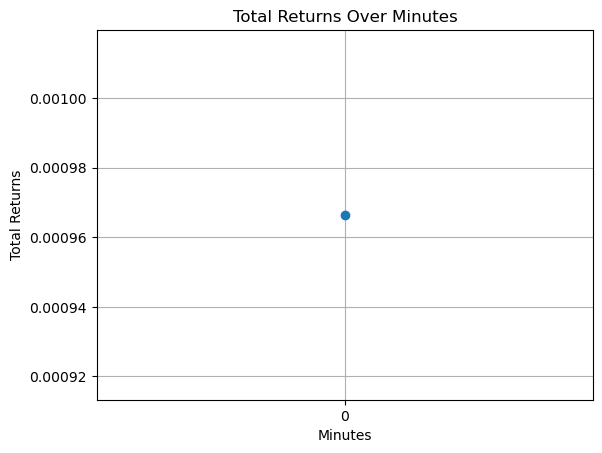

In [223]:
plt.plot(real_returns_vector, marker='o')
plt.xticks(ticks=range(len(real_returns_vector)), labels=[f"{i*10}" for i in range(len(real_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

## What if we have multiple strategies?

In [16]:
from sklearn.linear_model import LinearRegression

In [19]:
def build_combined_strategy(prev_1: pd.DataFrame, prev_2: pd.DataFrame,returns: pd.DataFrame) -> dict:
    """
    Combine two forecast‐based strategies (prev_1, prev_2) into a base‐+‐alpha portfolio 
    that maximizes Sharpe.  We assume:
    
    1) prev_1, prev_2 are each (T × N) DataFrames of *forecasted returns* for 
       strategies 1 and 2 (rows = time, cols = assets). 
    2) SR_1, SR_2 are the Sharpe ratios (ex‐ante or ex‐post) of those two strategies. 
    3) `returns` is a (T × N) DataFrame of *realized* returns of those same N assets, 
       in the same order, over the same T periods.
    
    Steps performed:
    ----------
    1) Run each forecast‐DataFrame through your existing `strategy(...)` function to 
       get a time‐series of weights: 
         W1_hist (T×N), W2_hist (T×N) 
       plus transaction costs (ignored here).
    2) Compute realized return‐series:
         r1_t = sum_i [ W1_hist[t,i] * realized_returns[t,i] ]  (t=0..T−1),
         r2_t = sum_i [ W2_hist[t,i] * realized_returns[t,i] ].
    3) Identify the “base” strategy b = argmax{SR_1, SR_2}, and the “lean” strategy ℓ = the other one.
    4) Regress r_{ℓ} on r_{b} to estimate α, β, and collect the residual series:
         r_{ℓ,t} = α + β * r_{b,t} + ε_t.
    5) Form the *pure‐alpha* portfolio’s weight‐vectors:
         for each t: 
           w^{(α)}_{t} = w^{(ℓ)}_{t}  –  β * w^{(b)}_{t}.
       Its realized returns are r_{ℓ,t} − β·r_{b,t} = α + ε_t, so 
       E[ r^{(α)} ] = α,  and  σ_{α} = StdDev( r_{ℓ} − β r_{b} ).
    6) Compute 
         SR_{α} = α / σ_{α}, 
         SR_{b} = max(SR_1, SR_2).
       Since r^{(b)} and r^{(α)} are (approximately) uncorrelated, the max‐Sharpe from mixing them is
         SR_combined = sqrt( SR_b^2 + SR_{α}^2 ).
    7) The dollar‐fractions to put on “base” vs. “pure‐alpha” 
       (so that the combined has unit volatility) are 
         f_b = SR_b / sqrt(SR_b^2 + SR_{α}^2), 
         f_α = SR_α / sqrt(SR_b^2 + SR_{α}^2).
    8) The combined *asset‐level* weights at time t are 
         W_comb_t = f_b·w^{(b)}_{t}  +  f_α·( w^{(ℓ)}_{t} − β·w^{(b)}_{t} ).
    9) We return:
       • alpha_hat, beta_hat, sigma_alpha, SR_alpha, SR_combined
       • the full T×N array W_combined_hist
       • the combined realized returns r_combined (length T) and its ex‐post Sharpe.
    """
    # 1) Run each “forecast‐DataFrame” through your existing strategy() 
    W1_hist, cost1 = strategy(prev_1)   # W1_hist: (T×N)
    W2_hist, cost2 = strategy(prev_2)   # W2_hist: (T×N)
    
    # 2) Compute realized per‐period returns:
    R_mat = returns.values              # (T×N) array of realized returns
    r1 = (R_mat * W1_hist).sum(axis=1)  # shape (T,)  = ∑_i w1_{t,i}·r_{t,i}
    r2 = (R_mat * W2_hist).sum(axis=1)  # shape (T,)  = ∑_i w2_{t,i}·r_{t,i}
    SR_1 = r1.mean() / r1.std(ddof=1)
    SR_2 = r2.mean() / r2.std(ddof=1)
    # 3) Identify base‐strategy “b” vs. lean‐strategy “ℓ”
    if SR_1 >= SR_2:
        SR_b = SR_1
        r_b  = r1
        r_l  = r2
        Wb   = W1_hist   # (T×N)
        Wl   = W2_hist   # (T×N)
        label_base = "strategy 1"
        label_lean = "strategy 2"
    else:
        SR_b = SR_2
        r_b  = r2
        r_l  = r1
        Wb   = W2_hist
        Wl   = W1_hist
        label_base = "strategy 2"
        label_lean = "strategy 1"
    
    # 4) Regress r_l on r_b:   r_l = α + β·r_b + ε
    Xmat = r_b.reshape(-1, 1)   # shape (T,1)
    yvec = r_l                  # shape (T,)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xmat, yvec)
    alpha_hat = float(lr.intercept_)
    beta_hat  = float(lr.coef_[0])
    
    # Residual‐series:   ε_t = r_l[t] − (α + β·r_b[t])
    residuals = r_l - (alpha_hat + beta_hat * r_b)  # shape (T,)
    
    # 5) Pure‐alpha returns = r_l − β·r_b = α + ε_t →  E[·] = α,  StdDev = σ_α
    sigma_alpha = residuals.std(ddof=1)
    
    # 6) Sharpe of pure‐alpha:
    if sigma_alpha <= 0:
        raise ValueError("sigma_alpha is zero; cannot form a pure‐alpha Sharpe.")
    SR_alpha = alpha_hat / sigma_alpha
    
    # 7) Combined max‐Sharpe = sqrt(SR_b^2 + SR_alpha^2)
    SR_combined = np.sqrt(SR_b**2 + SR_alpha**2)
    
    # 8) Dollar‐fractions on base vs. α (so that total vol = 1):
    f_b = SR_b / SR_combined
    f_a = SR_alpha / SR_combined
    
    # 9) Build the *asset‐level* weight‐history of the combined portfolio:
    #    At time t, 
    #      w^(α)_t = Wl[t,:]  −  β_hat·Wb[t,:]
    #    Combined weights: 
    #      W_comb_t = f_b·Wb[t,:]  +  f_a·w^(α)_t
    W_alpha_hist = Wl - (beta_hat * Wb)         # shape (T×N)
    W_combined_hist = f_b * Wb + f_a * W_alpha_hist  # shape (T×N)
    
    # Because Wb (per‐period) sums to 1 and Wl sums to 1,  each row of W_combined_hist
    # sums to f_b·1 + f_a·(1 − β_hat·1) = f_b + f_a·(1 − β_hat).  
    # In practice, since r_l − β r_b already includes the intercept α
    # (which is “invested in cash” implicitly), you do *not* need to force that Sum(W_combined)=1 every row.
    # If you do want to force “fully‐invested + zero‐cash” each row, you can re‐normalize each row by its sum.  
    # But then you would no longer get exactly “r_l − β·r_b” at each t.  
    # Strictly speaking, if “cash rate = 0”, then w^(α)_t = Wl[t] − β·Wb[t] *does* produce r_l − β·r_b exactly,
    # and the leftover (1 − β) is sitting in cash.  
    # Here we leave W_combined_hist as “dollar weights including any cash leftover.” 
    
    # 10) Compute the realized return‐series of the combined portfolio, plus ex‐post Sharpe
    R_comb = (R_mat * W_combined_hist).sum(axis=1)  # shape (T,)
    mu_comb = R_comb.mean()
    sigma_comb = R_comb.std(ddof=1)
    SR_expost_comb = mu_comb / sigma_comb if sigma_comb > 0 else np.nan
    
    return {
        "alpha_hat":        alpha_hat,
        "beta_hat":         beta_hat,
        "sigma_alpha":      sigma_alpha,
        "SR_alpha":         SR_alpha,
        "SR_base":          SR_b,
        "SR_combined":      SR_combined,
        "f_base":           f_b,
        "f_alpha":          f_a,
        "W_combined_hist":  pd.DataFrame(
                                W_combined_hist, 
                                index=returns.index, 
                                columns=returns.columns
                            ),   # (T×N) DataFrame
        "returns_combined": pd.Series(R_comb, index=returns.index),
        "SR_expost_comb":   SR_expost_comb,
        "label_base":       label_base,
        "label_lean":       label_lean
    }
